# 5x5 Grid World with Random Agent (Gymnasium Style)


## 1. Import Required Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time
from typing import Tuple, Optional, Dict, Any
from IPython.display import clear_output

## 2. Create Gymnasium-Style Grid Environment

In [2]:
class GridWorldEnv:
    """
    5x5 Grid World Environment following Gymnasium API
    
    Action Space: Discrete(4) - [0: up, 1: down, 2: left, 3: right]
    Observation Space: Tuple(2) - (row, col) position
    
    Rewards:
    - -0.1 for each step (encourage efficiency)
    - -0.5 for hitting walls
    - +10.0 for reaching goal
    """
    
    def __init__(self, size: int = 5):
        self.size = size
        self.grid = np.zeros((size, size))
        
        # Define action and observation spaces (Gymnasium style)
        self.action_space = list(range(4))  # 0: up, 1: down, 2: left, 3: right
        self.observation_space = (size, size)  # (row, col) coordinates
        
        # Action mappings
        self.action_to_direction = {
            0: (-1, 0),  # up
            1: (1, 0),   # down
            2: (0, -1),  # left
            3: (0, 1)    # right
        }
        self.action_names = ['up', 'down', 'left', 'right']
        
        # Initialize positions
        self.start_pos = (0, 0)
        self.goal_pos = (size-1, size-1)
        self.agent_pos = None
        
        # Mark goal on grid for visualization
        self.grid[self.goal_pos] = 1
        
        # Episode tracking
        self.step_count = 0
        self.max_episode_steps = 200
        
        print(f"GridWorld Environment Created!")
        print(f"Action Space: {len(self.action_space)} actions {self.action_names}")
        print(f"Observation Space: {self.observation_space}")
        print(f"Start Position: {self.start_pos}")
        print(f"Goal Position: {self.goal_pos}")
    
    def reset(self, seed: Optional[int] = None) -> Tuple[Tuple[int, int], Dict[str, Any]]:
        """Reset environment to initial state (Gymnasium API)"""
        if seed is not None:
            random.seed(seed)
            np.random.seed(seed)
            
        self.agent_pos = self.start_pos
        self.step_count = 0
        
        observation = self.agent_pos
        info = {"step_count": self.step_count}
        
        return observation, info
    
    def step(self, action: int) -> Tuple[Tuple[int, int], float, bool, bool, Dict[str, Any]]:
        """Take a step in the environment (Gymnasium API)"""
        if action not in self.action_space:
            raise ValueError(f"Invalid action {action}. Must be in {self.action_space}")
        
        # Get current position
        row, col = self.agent_pos
        
        # Calculate new position
        delta_row, delta_col = self.action_to_direction[action]
        new_row = row + delta_row
        new_col = col + delta_col
        
        # Check bounds and update position
        reward = -0.1  # Small penalty for each step
        if 0 <= new_row < self.size and 0 <= new_col < self.size:
            # Valid move
            self.agent_pos = (new_row, new_col)
        else:
            # Invalid move (hit wall)
            reward = -0.5  # Penalty for hitting wall
        
        # Check if goal is reached
        terminated = (self.agent_pos == self.goal_pos)
        if terminated:
            reward = 10.0  # Large reward for reaching goal
        
        # Check if episode should end due to step limit
        self.step_count += 1
        truncated = (self.step_count >= self.max_episode_steps)
        
        observation = self.agent_pos
        info = {
            "step_count": self.step_count,
            "action_name": self.action_names[action],
            "hit_wall": reward == -0.5
        }
        
        return observation, reward, terminated, truncated, info
    
    def render(self, mode: str = "human") -> Optional[np.ndarray]:
        """Render the environment (Gymnasium API)"""
        if mode == "human":
            self._render_human()
        elif mode == "rgb_array":
            return self._render_rgb_array()
        else:
            raise ValueError(f"Unsupported render mode: {mode}")
    
    def _render_human(self):
        """Render for human viewing"""
        fig, ax = plt.subplots(figsize=(6, 6))
        
        # Create visualization grid
        visual_grid = np.copy(self.grid)
        visual_grid[self.agent_pos] = 2  # Mark agent position
        
        # Color mapping: 0=white (empty), 1=red (goal), 2=blue (agent)
        colors = ['white', 'red', 'blue']
        cmap = plt.matplotlib.colors.ListedColormap(colors)
        
        # Plot grid
        ax.imshow(visual_grid, cmap=cmap, vmin=0, vmax=2)
        
        # Add grid lines
        ax.set_xticks(np.arange(-0.5, self.size, 1), minor=True)
        ax.set_yticks(np.arange(-0.5, self.size, 1), minor=True)
        ax.grid(which="minor", color="black", linestyle='-', linewidth=1)
        ax.tick_params(which="minor", size=0)
        
        # Remove major ticks
        ax.set_xticks([])
        ax.set_yticks([])
        
        # Labels and title
        ax.set_title(f'GridWorld - Step: {self.step_count}', fontsize=14, fontweight='bold')
        
        # Legend
        legend_elements = [
            plt.Rectangle((0,0),1,1, facecolor='white', edgecolor='black', label='Empty'),
            plt.Rectangle((0,0),1,1, facecolor='red', edgecolor='black', label='Goal'),
            plt.Rectangle((0,0),1,1, facecolor='blue', edgecolor='black', label='Agent')
        ]
        ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3)
        
        # Position info
        agent_text = f"Agent: {self.agent_pos}"
        goal_text = f"Goal: {self.goal_pos}"
        plt.figtext(0.02, 0.02, f"{agent_text} | {goal_text}", fontsize=10)
        
        plt.tight_layout()
        plt.show()
    
    def _render_rgb_array(self) -> np.ndarray:
        """Render as RGB array"""
        # Create RGB representation
        rgb_array = np.zeros((self.size, self.size, 3), dtype=np.uint8)
        
        # Fill in colors: white for empty, red for goal, blue for agent
        rgb_array[:, :] = [255, 255, 255]  # White background
        rgb_array[self.goal_pos] = [255, 0, 0]  # Red goal
        rgb_array[self.agent_pos] = [0, 0, 255]  # Blue agent
        
        return rgb_array
    
    def close(self):
        """Close the environment"""
        pass
    
    def sample_action(self) -> int:
        """Sample a random action from action space"""
        return random.choice(self.action_space)

# Create the environment
env = GridWorldEnv(5)

# Test basic functionality
obs, info = env.reset()
print(f"\nInitial observation: {obs}")
print(f"Initial info: {info}")

# Take a random step
action = env.sample_action()
obs, reward, terminated, truncated, info = env.step(action)
print(f"\nAfter action {action} ({env.action_names[action]}):")
print(f"Observation: {obs}, Reward: {reward}, Terminated: {terminated}, Info: {info}")

GridWorld Environment Created!
Action Space: 4 actions ['up', 'down', 'left', 'right']
Observation Space: (5, 5)
Start Position: (0, 0)
Goal Position: (4, 4)

Initial observation: (0, 0)
Initial info: {'step_count': 0}

After action 3 (right):
Observation: (0, 1), Reward: -0.1, Terminated: False, Info: {'step_count': 1, 'action_name': 'right', 'hit_wall': False}


## 3. Random Agent Implementation

=== Running Single Episode ===
Starting episode at (0, 0)
Step 10: up -> (0, 0), Reward: -0.1
Step 20: left -> (4, 2), Reward: -0.1


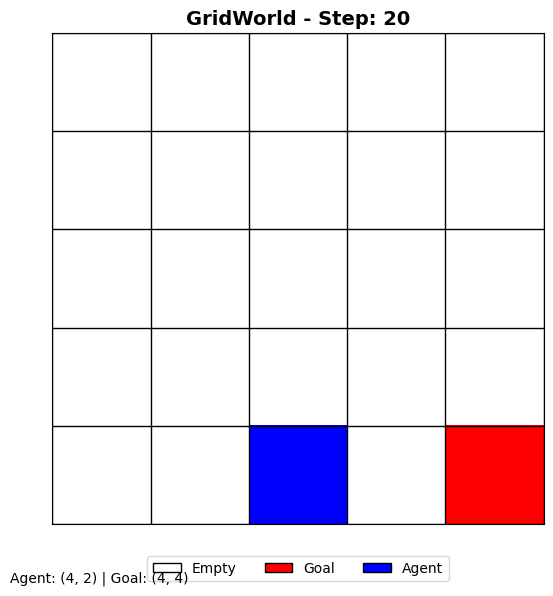

Step 30: left -> (4, 0), Reward: -0.1
Step 40: left -> (3, 0), Reward: -0.1


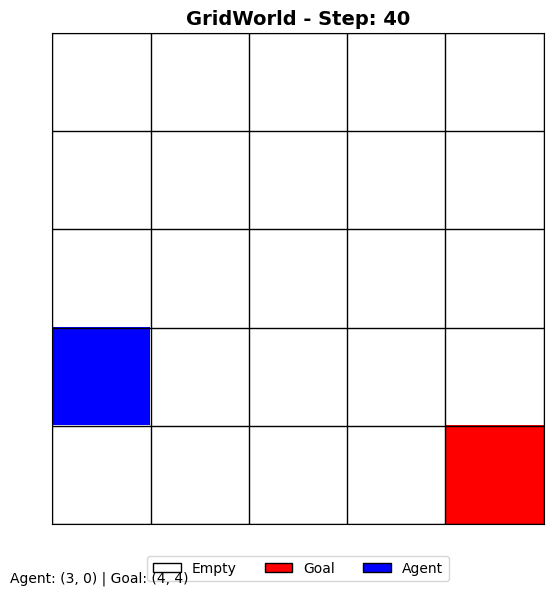

Step 50: up -> (0, 1), Reward: -0.5
Episode finished: TRUNCATED in 50 steps
Total reward: -9.40
Final position: (0, 1)

=== Final State ===


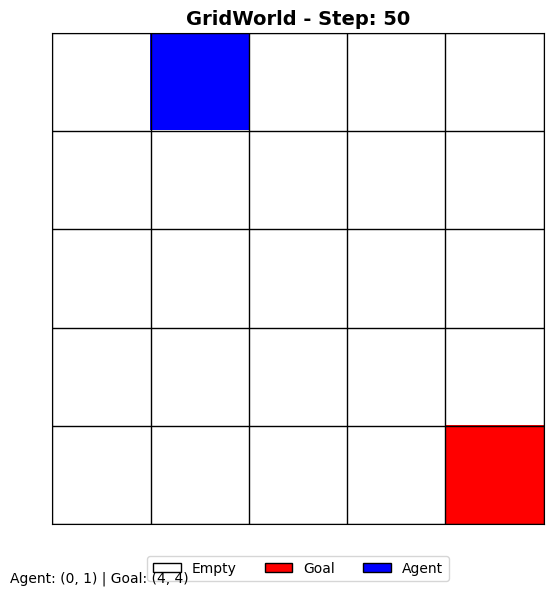

In [3]:
class RandomAgent:
    """
    Random Agent that selects actions uniformly at random
    Following the standard agent interface
    """
    
    def __init__(self, env: GridWorldEnv):
        self.env = env
        self.action_space = env.action_space
        
    def get_action(self, observation) -> int:
        """Get random action (policy)"""
        return self.env.sample_action()
    
    def reset(self):
        """Reset agent state (if needed)"""
        pass

def run_episode(env: GridWorldEnv, agent: RandomAgent, render: bool = False, max_steps: int = 200) -> Dict[str, Any]:
    """
    Run a single episode with the agent in the environment
    
    Returns:
        Dictionary with episode statistics
    """
    # Reset environment and agent
    observation, info = env.reset()
    agent.reset()
    
    # Episode tracking
    total_reward = 0
    steps = 0
    trajectory = [observation]
    actions_taken = []
    rewards_received = []
    
    print(f"Starting episode at {observation}")
    
    # Run episode
    while steps < max_steps:
        # Get action from agent
        action = agent.get_action(observation)
        action_name = env.action_names[action]
        
        # Take step in environment
        next_observation, reward, terminated, truncated, info = env.step(action)
        
        # Track episode data
        total_reward += reward
        steps += 1
        trajectory.append(next_observation)
        actions_taken.append(action_name)
        rewards_received.append(reward)
        
        # Optional rendering
        if render and (steps % 10 == 0 or terminated or truncated):
            print(f"Step {steps}: {action_name} -> {next_observation}, Reward: {reward:.1f}")
            if steps % 20 == 0:
                env.render()
        
        # Update observation
        observation = next_observation
        
        # Check if episode is done
        if terminated or truncated:
            break
    
    # Episode results
    success = terminated  # True if reached goal, False if truncated
    episode_stats = {
        "success": success,
        "total_reward": total_reward,
        "steps": steps,
        "final_position": observation,
        "trajectory": trajectory,
        "actions": actions_taken,
        "rewards": rewards_received
    }
    
    print(f"Episode finished: {'SUCCESS' if success else 'TRUNCATED'} in {steps} steps")
    print(f"Total reward: {total_reward:.2f}")
    print(f"Final position: {observation}")
    
    return episode_stats

# Create random agent
agent = RandomAgent(env)

# Run a single episode with detailed output
print("=== Running Single Episode ===")
episode_result = run_episode(env, agent, render=True, max_steps=50)

# Render final state
print("\n=== Final State ===")
env.render()

## 4. Multiple Episode Analysis

In [4]:
def run_multiple_episodes(env: GridWorldEnv, agent: RandomAgent, 
                         num_episodes: int = 100, max_steps: int = 200) -> Dict[str, Any]:
    """
    Run multiple episodes and collect statistics
    
    Returns:
        Dictionary with aggregated statistics
    """
    print(f"Running {num_episodes} episodes with random agent...")
    
    # Collect episode results
    all_results = []
    success_count = 0
    total_rewards = []
    episode_lengths = []
    
    for episode in range(num_episodes):
        # Run episode (without rendering for speed)
        result = run_episode(env, agent, render=False, max_steps=max_steps)
        all_results.append(result)
        
        # Track statistics
        if result["success"]:
            success_count += 1
        total_rewards.append(result["total_reward"])
        episode_lengths.append(result["steps"])
        
        # Progress update
        if (episode + 1) % 20 == 0:
            current_success_rate = (success_count / (episode + 1)) * 100
            avg_reward = np.mean(total_rewards)
            avg_steps = np.mean(episode_lengths)
            print(f"Episode {episode + 1}: Success Rate: {current_success_rate:.1f}%, "
                  f"Avg Reward: {avg_reward:.2f}, Avg Steps: {avg_steps:.1f}")
    
    # Calculate final statistics
    success_rate = (success_count / num_episodes) * 100
    avg_reward = np.mean(total_rewards)
    std_reward = np.std(total_rewards)
    avg_steps = np.mean(episode_lengths)
    std_steps = np.std(episode_lengths)
    min_steps = np.min(episode_lengths)
    max_steps_taken = np.max(episode_lengths)
    
    # Success-only statistics
    successful_episodes = [r for r in all_results if r["success"]]
    if successful_episodes:
        successful_rewards = [r["total_reward"] for r in successful_episodes]
        successful_steps = [r["steps"] for r in successful_episodes]
        avg_successful_reward = np.mean(successful_rewards)
        avg_successful_steps = np.mean(successful_steps)
    else:
        avg_successful_reward = 0
        avg_successful_steps = 0
    
    summary_stats = {
        "num_episodes": num_episodes,
        "success_count": success_count,
        "success_rate": success_rate,
        "avg_reward": avg_reward,
        "std_reward": std_reward,
        "avg_steps": avg_steps,
        "std_steps": std_steps,
        "min_steps": min_steps,
        "max_steps": max_steps_taken,
        "avg_successful_reward": avg_successful_reward,
        "avg_successful_steps": avg_successful_steps,
        "all_rewards": total_rewards,
        "all_steps": episode_lengths,
        "all_results": all_results
    }
    
    # Print summary
    print(f"\n{'='*50}")
    print(f"RANDOM AGENT PERFORMANCE SUMMARY")
    print(f"{'='*50}")
    print(f"Episodes run: {num_episodes}")
    print(f"Success rate: {success_rate:.1f}% ({success_count}/{num_episodes})")
    print(f"Average reward: {avg_reward:.2f} ± {std_reward:.2f}")
    print(f"Average steps: {avg_steps:.1f} ± {std_steps:.1f}")
    print(f"Step range: {min_steps} - {max_steps_taken}")
    if successful_episodes:
        print(f"Successful episodes - Avg reward: {avg_successful_reward:.2f}, Avg steps: {avg_successful_steps:.1f}")
    
    return summary_stats

# Run multiple episodes for analysis
results = run_multiple_episodes(env, agent, num_episodes=100, max_steps=200)

Running 100 episodes with random agent...
Starting episode at (0, 0)
Episode finished: SUCCESS in 75 steps
Total reward: -1.00
Final position: (4, 4)
Starting episode at (0, 0)
Episode finished: SUCCESS in 88 steps
Total reward: -10.70
Final position: (4, 4)
Starting episode at (0, 0)
Episode finished: SUCCESS in 27 steps
Total reward: 5.40
Final position: (4, 4)
Starting episode at (0, 0)
Episode finished: TRUNCATED in 200 steps
Total reward: -41.60
Final position: (4, 0)
Starting episode at (0, 0)
Episode finished: TRUNCATED in 200 steps
Total reward: -34.00
Final position: (3, 4)
Starting episode at (0, 0)
Episode finished: SUCCESS in 84 steps
Total reward: -3.90
Final position: (4, 4)
Starting episode at (0, 0)
Episode finished: TRUNCATED in 200 steps
Total reward: -30.40
Final position: (4, 2)
Starting episode at (0, 0)
Episode finished: SUCCESS in 38 steps
Total reward: 3.90
Final position: (4, 4)
Starting episode at (0, 0)
Episode finished: SUCCESS in 62 steps
Total reward: -3.3

## 5. Visualization and Analysis

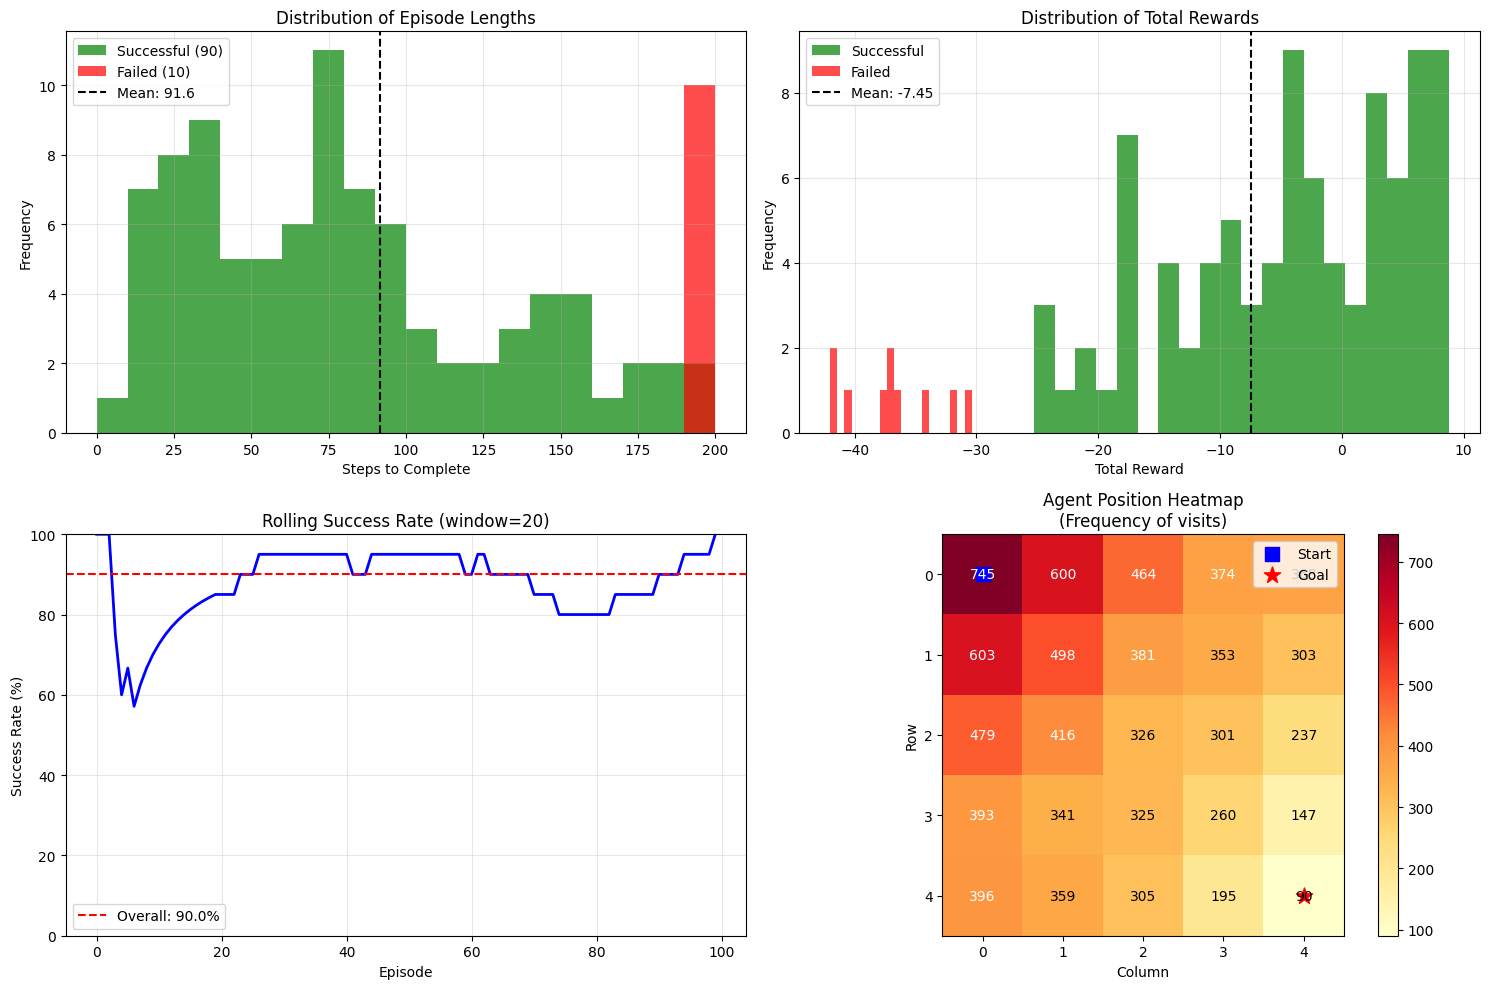

In [5]:
def visualize_results(results: Dict[str, Any]):
    """Visualize the results from multiple episodes"""
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Histogram of episode lengths
    successful_steps = [r["steps"] for r in results["all_results"] if r["success"]]
    failed_steps = [r["steps"] for r in results["all_results"] if not r["success"]]
    
    bins = np.arange(0, max(results["all_steps"]) + 10, 10)
    ax1.hist(successful_steps, bins=bins, alpha=0.7, label=f'Successful ({len(successful_steps)})', color='green')
    ax1.hist(failed_steps, bins=bins, alpha=0.7, label=f'Failed ({len(failed_steps)})', color='red')
    ax1.axvline(results["avg_steps"], color='black', linestyle='--', 
                label=f'Mean: {results["avg_steps"]:.1f}')
    ax1.set_xlabel('Steps to Complete')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Distribution of Episode Lengths')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Histogram of total rewards
    successful_rewards = [r["total_reward"] for r in results["all_results"] if r["success"]]
    failed_rewards = [r["total_reward"] for r in results["all_results"] if not r["success"]]
    
    ax2.hist(successful_rewards, bins=20, alpha=0.7, label=f'Successful', color='green')
    ax2.hist(failed_rewards, bins=20, alpha=0.7, label=f'Failed', color='red')
    ax2.axvline(results["avg_reward"], color='black', linestyle='--', 
                label=f'Mean: {results["avg_reward"]:.2f}')
    ax2.set_xlabel('Total Reward')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Distribution of Total Rewards')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Success rate over time (rolling average)
    window_size = 20
    success_over_time = [1 if r["success"] else 0 for r in results["all_results"]]
    rolling_success = []
    for i in range(len(success_over_time)):
        start_idx = max(0, i - window_size + 1)
        rolling_success.append(np.mean(success_over_time[start_idx:i+1]) * 100)
    
    ax3.plot(rolling_success, color='blue', linewidth=2)
    ax3.axhline(results["success_rate"], color='red', linestyle='--', 
                label=f'Overall: {results["success_rate"]:.1f}%')
    ax3.set_xlabel('Episode')
    ax3.set_ylabel('Success Rate (%)')
    ax3.set_title(f'Rolling Success Rate (window={window_size})')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.set_ylim(0, 100)
    
    # 4. Trajectory heatmap (where agent spends time)
    position_counts = np.zeros((env.size, env.size))
    for result in results["all_results"]:
        for pos in result["trajectory"]:
            position_counts[pos] += 1
    
    im = ax4.imshow(position_counts, cmap='YlOrRd', interpolation='nearest')
    ax4.set_title('Agent Position Heatmap\n(Frequency of visits)')
    ax4.set_xlabel('Column')
    ax4.set_ylabel('Row')
    
    # Add text annotations
    for i in range(env.size):
        for j in range(env.size):
            ax4.text(j, i, f'{int(position_counts[i, j])}', 
                    ha='center', va='center', 
                    color='white' if position_counts[i, j] > np.max(position_counts)/2 else 'black')
    
    # Mark start and goal
    ax4.scatter([0], [0], marker='s', s=100, c='blue', label='Start')
    ax4.scatter([env.size-1], [env.size-1], marker='*', s=150, c='red', label='Goal')
    ax4.legend()
    
    plt.colorbar(im, ax=ax4)
    plt.tight_layout()
    plt.show()

# Visualize the results
visualize_results(results)

## 6. Interactive Episode Playback

🔍 Searching for a successful episode to demonstrate...
Starting episode at (0, 0)
Episode finished: SUCCESS in 51 steps
Total reward: 1.40
Final position: (4, 4)

✅ Found successful episode after 1 attempts!
Steps taken: 51
Total reward: 1.40
Path taken: (0, 0) → (0, 1) → (0, 0) → (0, 1) → (1, 1) → (1, 0) → (1, 0) → (0, 0) → (0, 1) → (0, 2) → (0, 3) → (0, 4) → (0, 3) → (0, 4) → (0, 3) → (0, 2) → (0, 3) → (0, 3) → (0, 2) → (0, 2) → (0, 2) → (0, 2) → (0, 2) → (0, 1) → (0, 0) → (1, 0) → (2, 0) → (2, 1) → (2, 0) → (1, 0) → (1, 1) → (0, 1) → (0, 2) → (1, 2) → (0, 2) → (0, 3) → (0, 3) → (1, 3) → (1, 2) → (0, 2) → (0, 1) → (0, 0) → (0, 0) → (1, 0) → (2, 0) → (3, 0) → (3, 0) → (3, 1) → (3, 2) → (3, 3) → (3, 4) → (4, 4)


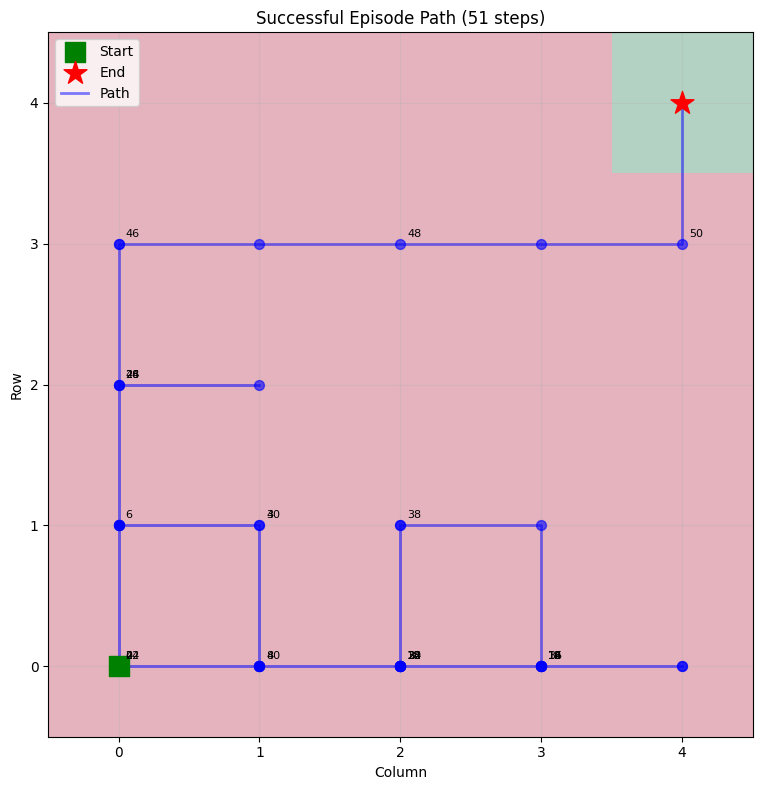

In [6]:
def play_episode_animation(env: GridWorldEnv, agent: RandomAgent, max_steps: int = 50, delay: float = 0.5):
    """
    Play an animated episode showing agent movement step by step
    """
    print("🎮 Starting animated episode playback...")
    
    # Reset environment
    observation, info = env.reset()
    agent.reset()
    
    step_count = 0
    total_reward = 0
    
    print(f"Starting position: {observation}")
    env.render()
    time.sleep(delay)
    
    while step_count < max_steps:
        # Get action
        action = agent.get_action(observation)
        action_name = env.action_names[action]
        
        # Take step
        next_observation, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        step_count += 1
        
        # Clear output and show new state
        clear_output(wait=True)
        print(f"🎮 Animated Episode Playback - Step {step_count}")
        print(f"Action: {action_name} | Position: {observation} → {next_observation}")
        print(f"Reward: {reward:.1f} | Total Reward: {total_reward:.1f}")
        print(f"Hit wall: {'Yes' if info.get('hit_wall', False) else 'No'}")
        
        # Update position and render
        observation = next_observation
        env.render()
        
        # Check if done
        if terminated:
            print(f"\n🎉 SUCCESS! Reached goal in {step_count} steps!")
            print(f"Final reward: {total_reward:.1f}")
            break
        elif truncated:
            print(f"\n⏰ Episode truncated after {step_count} steps")
            break
        
        # Wait before next step
        time.sleep(delay)
    
    return {
        "success": terminated,
        "steps": step_count,
        "total_reward": total_reward,
        "final_position": observation
    }

def show_successful_episode_example():
    """Show an example of a successful episode by running until we find one"""
    print("🔍 Searching for a successful episode to demonstrate...")
    
    attempts = 0
    max_attempts = 20
    
    while attempts < max_attempts:
        attempts += 1
        result = run_episode(env, agent, render=False, max_steps=100)
        
        if result["success"]:
            print(f"\n✅ Found successful episode after {attempts} attempts!")
            print(f"Steps taken: {result['steps']}")
            print(f"Total reward: {result['total_reward']:.2f}")
            print(f"Path taken: {' → '.join(map(str, result['trajectory']))}")
            
            # Visualize the successful path
            fig, ax = plt.subplots(figsize=(8, 8))
            
            # Create base grid
            visual_grid = np.zeros((env.size, env.size))
            visual_grid[env.goal_pos] = 1  # Mark goal
            
            # Plot path
            trajectory = result['trajectory']
            for i, pos in enumerate(trajectory):
                if i == 0:
                    ax.scatter(pos[1], pos[0], c='green', s=200, marker='s', label='Start', zorder=3)
                elif i == len(trajectory) - 1:
                    ax.scatter(pos[1], pos[0], c='red', s=300, marker='*', label='End', zorder=3)
                else:
                    ax.scatter(pos[1], pos[0], c='blue', s=50, alpha=0.6, zorder=2)
            
            # Draw path lines
            path_x = [pos[1] for pos in trajectory]
            path_y = [pos[0] for pos in trajectory]
            ax.plot(path_x, path_y, 'b-', alpha=0.5, linewidth=2, label='Path')
            
            # Format plot
            ax.imshow(visual_grid, cmap='RdYlGn', alpha=0.3)
            ax.set_xlim(-0.5, env.size - 0.5)
            ax.set_ylim(-0.5, env.size - 0.5)
            ax.set_xlabel('Column')
            ax.set_ylabel('Row')
            ax.set_title(f'Successful Episode Path ({result["steps"]} steps)')
            ax.legend()
            ax.grid(True, alpha=0.3)
            
            # Add step numbers
            for i, pos in enumerate(trajectory[::2]):  # Show every other step to avoid clutter
                ax.annotate(f'{i*2}', (pos[1], pos[0]), xytext=(5, 5), 
                           textcoords='offset points', fontsize=8)
            
            plt.tight_layout()
            plt.show()
            return result
    
    print(f"❌ Could not find a successful episode in {max_attempts} attempts")
    return None

# Show an example of a successful episode
successful_example = show_successful_episode_example()

## 8. Advanced Agent Implementations


### 8.1 Value Iteration Agent

Creating Value Iteration Agent...
Value iteration converged after 9 iterations

Testing Value Iteration Agent:
Starting episode at (0, 0)
Episode finished: SUCCESS in 8 steps
Total reward: 9.30
Final position: (4, 4)
Value Iteration Result: SUCCESS in 8 steps
Total reward: 9.30


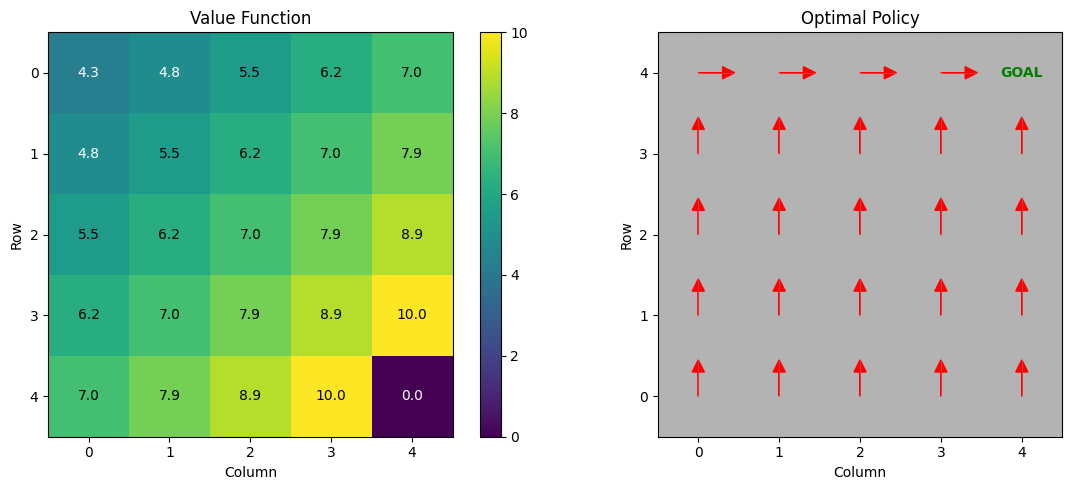

In [7]:
class ValueIterationAgent:
    """
    Value Iteration Agent - Uses dynamic programming to compute optimal policy
    
    The agent computes the optimal value function using the Bellman equation:
    V(s) = max_a Σ_s' P(s'|s,a) * [R(s,a,s') + γ * V(s')]
    """
    
    def __init__(self, env: GridWorldEnv, discount=0.9, theta=1e-6):
        self.env = env
        self.discount = discount
        self.theta = theta  # Convergence threshold
        
        # Initialize value function for all states
        self.values = {}
        self.policy = {}
        
        # Initialize all state values to 0
        for row in range(env.size):
            for col in range(env.size):
                state = (row, col)
                self.values[state] = 0.0
                self.policy[state] = 0  # Default action
        
        # Compute optimal policy using value iteration
        self.value_iteration()
        self.extract_policy()
    
    def get_next_state(self, state, action):
        """Get next state given current state and action"""
        row, col = state
        delta_row, delta_col = self.env.action_to_direction[action]
        new_row = row + delta_row
        new_col = col + delta_col
        
        # Check bounds
        if 0 <= new_row < self.env.size and 0 <= new_col < self.env.size:
            return (new_row, new_col)
        else:
            return state  # Stay in same state if hitting wall
    
    def get_reward(self, state, action, next_state):
        """Get reward for transition"""
        if next_state == self.env.goal_pos:
            return 10.0  # Goal reward
        elif next_state == state:  # Hit wall
            return -0.5
        else:
            return -0.1  # Step penalty
    
    def value_iteration(self):
        """Perform value iteration algorithm"""
        iteration = 0
        
        while True:
            iteration += 1
            delta = 0
            old_values = self.values.copy()
            
            # Update value for each state
            for state in self.values:
                if state == self.env.goal_pos:
                    continue  # Goal state has value 0 (terminal)
                
                # Compute value for all possible actions
                action_values = []
                for action in self.env.action_space:
                    next_state = self.get_next_state(state, action)
                    reward = self.get_reward(state, action, next_state)
                    value = reward + self.discount * old_values[next_state]
                    action_values.append(value)
                
                # Take maximum value
                new_value = max(action_values)
                delta = max(delta, abs(new_value - self.values[state]))
                self.values[state] = new_value
            
            # Check for convergence
            if delta < self.theta:
                print(f"Value iteration converged after {iteration} iterations")
                break
    
    def extract_policy(self):
        """Extract optimal policy from value function"""
        for state in self.values:
            if state == self.env.goal_pos:
                continue
            
            # Find best action for this state
            best_action = 0
            best_value = float('-inf')
            
            for action in self.env.action_space:
                next_state = self.get_next_state(state, action)
                reward = self.get_reward(state, action, next_state)
                value = reward + self.discount * self.values[next_state]
                
                if value > best_value:
                    best_value = value
                    best_action = action
            
            self.policy[state] = best_action
    
    def get_action(self, observation):
        """Get action according to optimal policy"""
        return self.policy.get(observation, 0)
    
    def reset(self):
        """Reset agent (no state to reset for this agent)"""
        pass

# Create and test Value Iteration agent
print("Creating Value Iteration Agent...")
vi_agent = ValueIterationAgent(env)

# Test the agent
print("\nTesting Value Iteration Agent:")
vi_result = run_episode(env, vi_agent, render=False, max_steps=50)
print(f"Value Iteration Result: {'SUCCESS' if vi_result['success'] else 'FAILED'} in {vi_result['steps']} steps")
print(f"Total reward: {vi_result['total_reward']:.2f}")

# Show the value function as a heatmap
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot value function
values_grid = np.zeros((env.size, env.size))
for row in range(env.size):
    for col in range(env.size):
        values_grid[row, col] = vi_agent.values[(row, col)]

im1 = ax1.imshow(values_grid, cmap='viridis')
ax1.set_title('Value Function')
ax1.set_xlabel('Column')
ax1.set_ylabel('Row')
for row in range(env.size):
    for col in range(env.size):
        ax1.text(col, row, f'{values_grid[row, col]:.1f}', 
                ha='center', va='center', color='white' if values_grid[row, col] < np.max(values_grid)/2 else 'black')
plt.colorbar(im1, ax=ax1)

# Plot policy as arrows
ax2.imshow(np.zeros((env.size, env.size)), cmap='gray', alpha=0.3)
arrow_props = {'head_width': 0.15, 'head_length': 0.15, 'fc': 'red', 'ec': 'red'}
action_arrows = {0: (0, -0.3), 1: (0, 0.3), 2: (-0.3, 0), 3: (0.3, 0)}

for row in range(env.size):
    for col in range(env.size):
        if (row, col) == env.goal_pos:
            ax2.text(col, row, 'GOAL', ha='center', va='center', fontweight='bold', color='green')
            continue
        
        action = vi_agent.policy[(row, col)]
        dx, dy = action_arrows[action]
        ax2.arrow(col, row, dx, dy, **arrow_props)

ax2.set_title('Optimal Policy')
ax2.set_xlabel('Column')
ax2.set_ylabel('Row')
ax2.set_xlim(-0.5, env.size - 0.5)
ax2.set_ylim(-0.5, env.size - 0.5)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 8.2 Policy Iteration Agent

Creating Policy Iteration Agent...
Policy iteration converged after 9 iterations

Testing Policy Iteration Agent:
Starting episode at (0, 0)
Episode finished: SUCCESS in 8 steps
Total reward: 9.30
Final position: (4, 4)
Policy Iteration Result: SUCCESS in 8 steps
Total reward: 9.30

Comparing VI and PI policies:
Policies differ in 1 out of 25 states


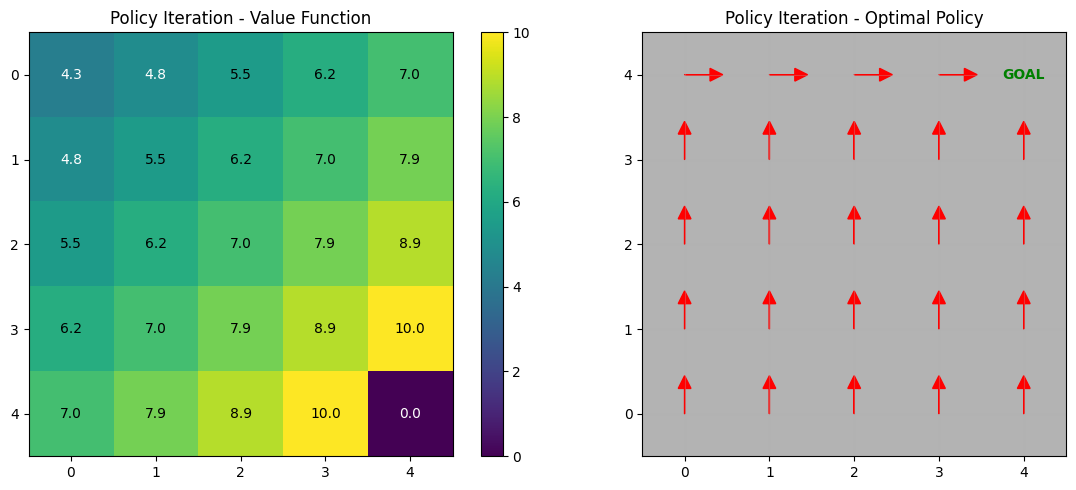

In [8]:
class PolicyIterationAgent:
    """
    Policy Iteration Agent - Uses dynamic programming with policy evaluation and improvement
    
    Alternates between:
    1. Policy Evaluation: Compute value function for current policy
    2. Policy Improvement: Update policy based on value function
    """
    
    def __init__(self, env: GridWorldEnv, discount=0.9, theta=1e-6):
        self.env = env
        self.discount = discount
        self.theta = theta
        
        # Initialize random policy and value function
        self.policy = {}
        self.values = {}
        
        # Initialize with random policy
        for row in range(env.size):
            for col in range(env.size):
                state = (row, col)
                self.policy[state] = np.random.choice(env.action_space)
                self.values[state] = 0.0
        
        # Run policy iteration
        self.policy_iteration()
    
    def get_next_state(self, state, action):
        """Get next state given current state and action"""
        row, col = state
        delta_row, delta_col = self.env.action_to_direction[action]
        new_row = row + delta_row
        new_col = col + delta_col
        
        # Check bounds
        if 0 <= new_row < self.env.size and 0 <= new_col < self.env.size:
            return (new_row, new_col)
        else:
            return state  # Stay in same state if hitting wall
    
    def get_reward(self, state, action, next_state):
        """Get reward for transition"""
        if next_state == self.env.goal_pos:
            return 10.0
        elif next_state == state:  # Hit wall
            return -0.5
        else:
            return -0.1
    
    def policy_evaluation(self):
        """Evaluate current policy"""
        while True:
            delta = 0
            old_values = self.values.copy()
            
            for state in self.values:
                if state == self.env.goal_pos:
                    continue  # Terminal state
                
                action = self.policy[state]
                next_state = self.get_next_state(state, action)
                reward = self.get_reward(state, action, next_state)
                new_value = reward + self.discount * old_values[next_state]
                
                delta = max(delta, abs(new_value - self.values[state]))
                self.values[state] = new_value
            
            if delta < self.theta:
                break
    
    def policy_improvement(self):
        """Improve policy based on current value function"""
        policy_stable = True
        
        for state in self.policy:
            if state == self.env.goal_pos:
                continue
            
            old_action = self.policy[state]
            
            # Find best action
            best_action = 0
            best_value = float('-inf')
            
            for action in self.env.action_space:
                next_state = self.get_next_state(state, action)
                reward = self.get_reward(state, action, next_state)
                value = reward + self.discount * self.values[next_state]
                
                if value > best_value:
                    best_value = value
                    best_action = action
            
            self.policy[state] = best_action
            
            if old_action != best_action:
                policy_stable = False
        
        return policy_stable
    
    def policy_iteration(self):
        """Run policy iteration algorithm"""
        iteration = 0
        
        while True:
            iteration += 1
            
            # Policy evaluation
            self.policy_evaluation()
            
            # Policy improvement
            policy_stable = self.policy_improvement()
            
            if policy_stable:
                print(f"Policy iteration converged after {iteration} iterations")
                break
    
    def get_action(self, observation):
        """Get action according to current policy"""
        return self.policy.get(observation, 0)
    
    def reset(self):
        """Reset agent"""
        pass

# Create and test Policy Iteration agent
print("Creating Policy Iteration Agent...")
pi_agent = PolicyIterationAgent(env)

# Test the agent
print("\nTesting Policy Iteration Agent:")
pi_result = run_episode(env, pi_agent, render=False, max_steps=50)
print(f"Policy Iteration Result: {'SUCCESS' if pi_result['success'] else 'FAILED'} in {pi_result['steps']} steps")
print(f"Total reward: {pi_result['total_reward']:.2f}")

# Compare policies of Value Iteration vs Policy Iteration
print("\nComparing VI and PI policies:")
different_states = 0
for state in vi_agent.policy:
    if vi_agent.policy[state] != pi_agent.policy[state]:
        different_states += 1
        
print(f"Policies differ in {different_states} out of {len(vi_agent.policy)} states")

# Visualize Policy Iteration results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot value function
values_grid = np.zeros((env.size, env.size))
for row in range(env.size):
    for col in range(env.size):
        values_grid[row, col] = pi_agent.values[(row, col)]

im1 = ax1.imshow(values_grid, cmap='viridis')
ax1.set_title('Policy Iteration - Value Function')
for row in range(env.size):
    for col in range(env.size):
        ax1.text(col, row, f'{values_grid[row, col]:.1f}', 
                ha='center', va='center', color='white' if values_grid[row, col] < np.max(values_grid)/2 else 'black')
plt.colorbar(im1, ax=ax1)

# Plot policy
ax2.imshow(np.zeros((env.size, env.size)), cmap='gray', alpha=0.3)
for row in range(env.size):
    for col in range(env.size):
        if (row, col) == env.goal_pos:
            ax2.text(col, row, 'GOAL', ha='center', va='center', fontweight='bold', color='green')
            continue
        
        action = pi_agent.policy[(row, col)]
        dx, dy = action_arrows[action]
        ax2.arrow(col, row, dx, dy, **arrow_props)

ax2.set_title('Policy Iteration - Optimal Policy')
ax2.set_xlim(-0.5, env.size - 0.5)
ax2.set_ylim(-0.5, env.size - 0.5)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 8.3 Q-Learning Agent

Creating Q-Learning Agent...
Training Q-Learning agent for 500 episodes...
Episode 100: Avg Reward: 3.59, Success Rate: 99.0%, Epsilon: 0.606
Episode 200: Avg Reward: 8.20, Success Rate: 99.5%, Epsilon: 0.367
Episode 300: Avg Reward: 8.81, Success Rate: 99.7%, Epsilon: 0.222
Episode 400: Avg Reward: 9.04, Success Rate: 99.8%, Epsilon: 0.135
Episode 500: Avg Reward: 9.16, Success Rate: 99.8%, Epsilon: 0.082
Training completed! Final success rate: 99.8%

Testing Q-Learning Agent:
Starting episode at (0, 0)
Episode finished: SUCCESS in 8 steps
Total reward: 9.30
Final position: (4, 4)
Q-Learning Result: SUCCESS in 8 steps
Total reward: 9.30


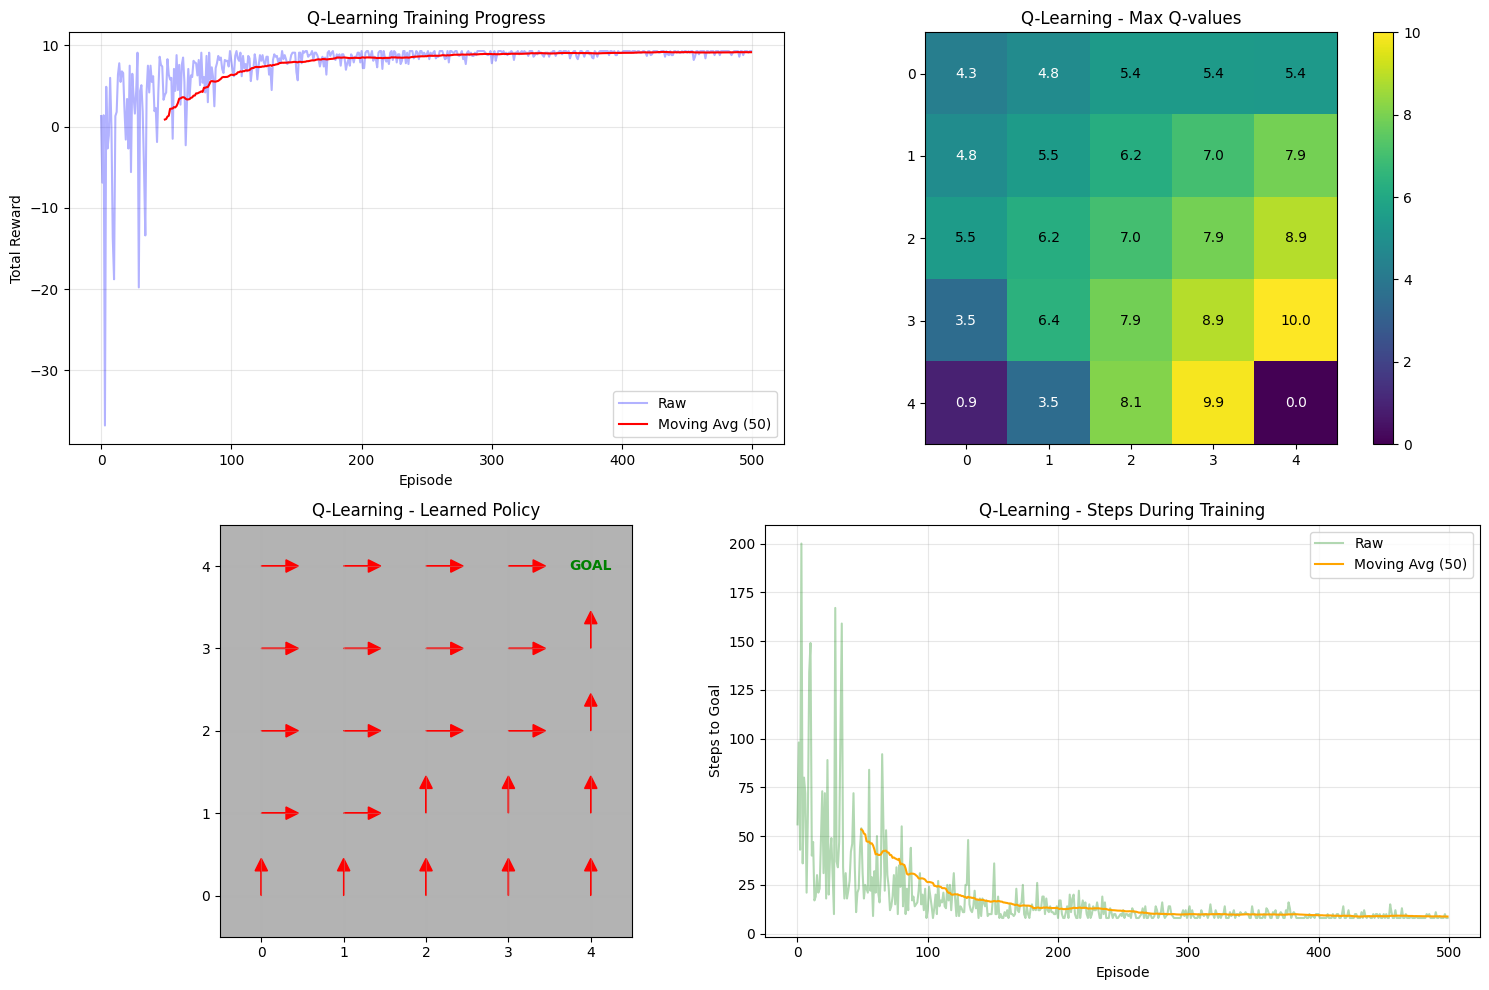

In [9]:
class QLearningAgent:
    """
    Q-Learning Agent - Model-free reinforcement learning
    
    Uses the Q-learning update rule:
    Q(s,a) = Q(s,a) + α[r + γ * max_a' Q(s',a') - Q(s,a)]
    """
    
    def __init__(self, env: GridWorldEnv, learning_rate=0.1, discount=0.9, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.env = env
        self.learning_rate = learning_rate
        self.discount = discount
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        
        # Initialize Q-table
        self.q_table = {}
        for row in range(env.size):
            for col in range(env.size):
                state = (row, col)
                self.q_table[state] = [0.0] * len(env.action_space)
        
        # Training tracking
        self.training_rewards = []
        self.training_steps = []
        
        # Train the agent
        self.train(episodes=500)
    
    def get_action(self, observation):
        """Epsilon-greedy action selection"""
        if np.random.random() < self.epsilon:
            return np.random.choice(self.env.action_space)
        else:
            q_values = self.q_table[observation]
            return np.argmax(q_values)
    
    def update_q_value(self, state, action, reward, next_state):
        """Update Q-value using Q-learning rule"""
        current_q = self.q_table[state][action]
        next_max_q = max(self.q_table[next_state])
        new_q = current_q + self.learning_rate * (reward + self.discount * next_max_q - current_q)
        self.q_table[state][action] = new_q
    
    def train(self, episodes=500):
        """Train the Q-learning agent"""
        print(f"Training Q-Learning agent for {episodes} episodes...")
        success_count = 0
        
        for episode in range(episodes):
            observation, _ = self.env.reset()
            total_reward = 0
            steps = 0
            
            for step in range(200):  # Max steps per episode
                action = self.get_action(observation)
                next_observation, reward, terminated, truncated, _ = self.env.step(action)
                
                # Update Q-value
                self.update_q_value(observation, action, reward, next_observation)
                
                observation = next_observation
                total_reward += reward
                steps += 1
                
                if terminated:
                    success_count += 1
                    break
                
                if truncated:
                    break
            
            # Decay epsilon
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay
            
            self.training_rewards.append(total_reward)
            self.training_steps.append(steps)
            
            # Progress update
            if (episode + 1) % 100 == 0:
                avg_reward = np.mean(self.training_rewards[-100:])
                avg_steps = np.mean(self.training_steps[-100:])
                success_rate = (success_count / (episode + 1)) * 100
                print(f"Episode {episode + 1}: Avg Reward: {avg_reward:.2f}, Success Rate: {success_rate:.1f}%, Epsilon: {self.epsilon:.3f}")
        
        # Set epsilon to 0 for testing (pure exploitation)
        self.epsilon = 0
        print(f"Training completed! Final success rate: {(success_count / episodes) * 100:.1f}%")
    
    def reset(self):
        """Reset agent"""
        pass

# Create and test Q-Learning agent
print("Creating Q-Learning Agent...")
ql_agent = QLearningAgent(env)

# Test the agent
print("\nTesting Q-Learning Agent:")
ql_result = run_episode(env, ql_agent, render=False, max_steps=50)
print(f"Q-Learning Result: {'SUCCESS' if ql_result['success'] else 'FAILED'} in {ql_result['steps']} steps")
print(f"Total reward: {ql_result['total_reward']:.2f}")

# Visualize Q-Learning results
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Plot training progress
window_size = 50
if len(ql_agent.training_rewards) > window_size:
    smoothed_rewards = np.convolve(ql_agent.training_rewards, np.ones(window_size)/window_size, mode='valid')
    ax1.plot(ql_agent.training_rewards, alpha=0.3, color='blue', label='Raw')
    ax1.plot(range(window_size-1, len(ql_agent.training_rewards)), smoothed_rewards, color='red', label=f'Moving Avg ({window_size})')
else:
    ax1.plot(ql_agent.training_rewards, color='blue', label='Training Rewards')
ax1.set_xlabel('Episode')
ax1.set_ylabel('Total Reward')
ax1.set_title('Q-Learning Training Progress')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot Q-values heatmap
q_values_max = np.zeros((env.size, env.size))
for row in range(env.size):
    for col in range(env.size):
        q_values_max[row, col] = max(ql_agent.q_table[(row, col)])

im = ax2.imshow(q_values_max, cmap='viridis')
ax2.set_title('Q-Learning - Max Q-values')
for row in range(env.size):
    for col in range(env.size):
        ax2.text(col, row, f'{q_values_max[row, col]:.1f}', 
                ha='center', va='center', color='white' if q_values_max[row, col] < np.max(q_values_max)/2 else 'black')
plt.colorbar(im, ax=ax2)

# Plot learned policy
ax3.imshow(np.zeros((env.size, env.size)), cmap='gray', alpha=0.3)
for row in range(env.size):
    for col in range(env.size):
        if (row, col) == env.goal_pos:
            ax3.text(col, row, 'GOAL', ha='center', va='center', fontweight='bold', color='green')
            continue
        
        q_values = ql_agent.q_table[(row, col)]
        best_action = np.argmax(q_values)
        dx, dy = action_arrows[best_action]
        ax3.arrow(col, row, dx, dy, **arrow_props)

ax3.set_title('Q-Learning - Learned Policy')
ax3.set_xlim(-0.5, env.size - 0.5)
ax3.set_ylim(-0.5, env.size - 0.5)
ax3.grid(True, alpha=0.3)

# Plot steps during training
if len(ql_agent.training_steps) > window_size:
    smoothed_steps = np.convolve(ql_agent.training_steps, np.ones(window_size)/window_size, mode='valid')
    ax4.plot(ql_agent.training_steps, alpha=0.3, color='green', label='Raw')
    ax4.plot(range(window_size-1, len(ql_agent.training_steps)), smoothed_steps, color='orange', label=f'Moving Avg ({window_size})')
else:
    ax4.plot(ql_agent.training_steps, color='green', label='Training Steps')
ax4.set_xlabel('Episode')
ax4.set_ylabel('Steps to Goal')
ax4.set_title('Q-Learning - Steps During Training')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 8.4 Monte Carlo Agent

Creating Monte Carlo Agent...
Training Monte Carlo agent for 1000 episodes...
Episode 200: Avg Reward: 5.77, Success Rate: 98.5%, Epsilon: 0.367
Episode 400: Avg Reward: 8.88, Success Rate: 99.2%, Epsilon: 0.135
Episode 600: Avg Reward: 9.16, Success Rate: 99.5%, Epsilon: 0.049
Episode 800: Avg Reward: 9.26, Success Rate: 99.6%, Epsilon: 0.018
Episode 1000: Avg Reward: 9.29, Success Rate: 99.7%, Epsilon: 0.010
Training completed! Final success rate: 99.7%

Testing Monte Carlo Agent:
Starting episode at (0, 0)
Episode finished: SUCCESS in 8 steps
Total reward: 9.30
Final position: (4, 4)
Monte Carlo Result: SUCCESS in 8 steps
Total reward: 9.30


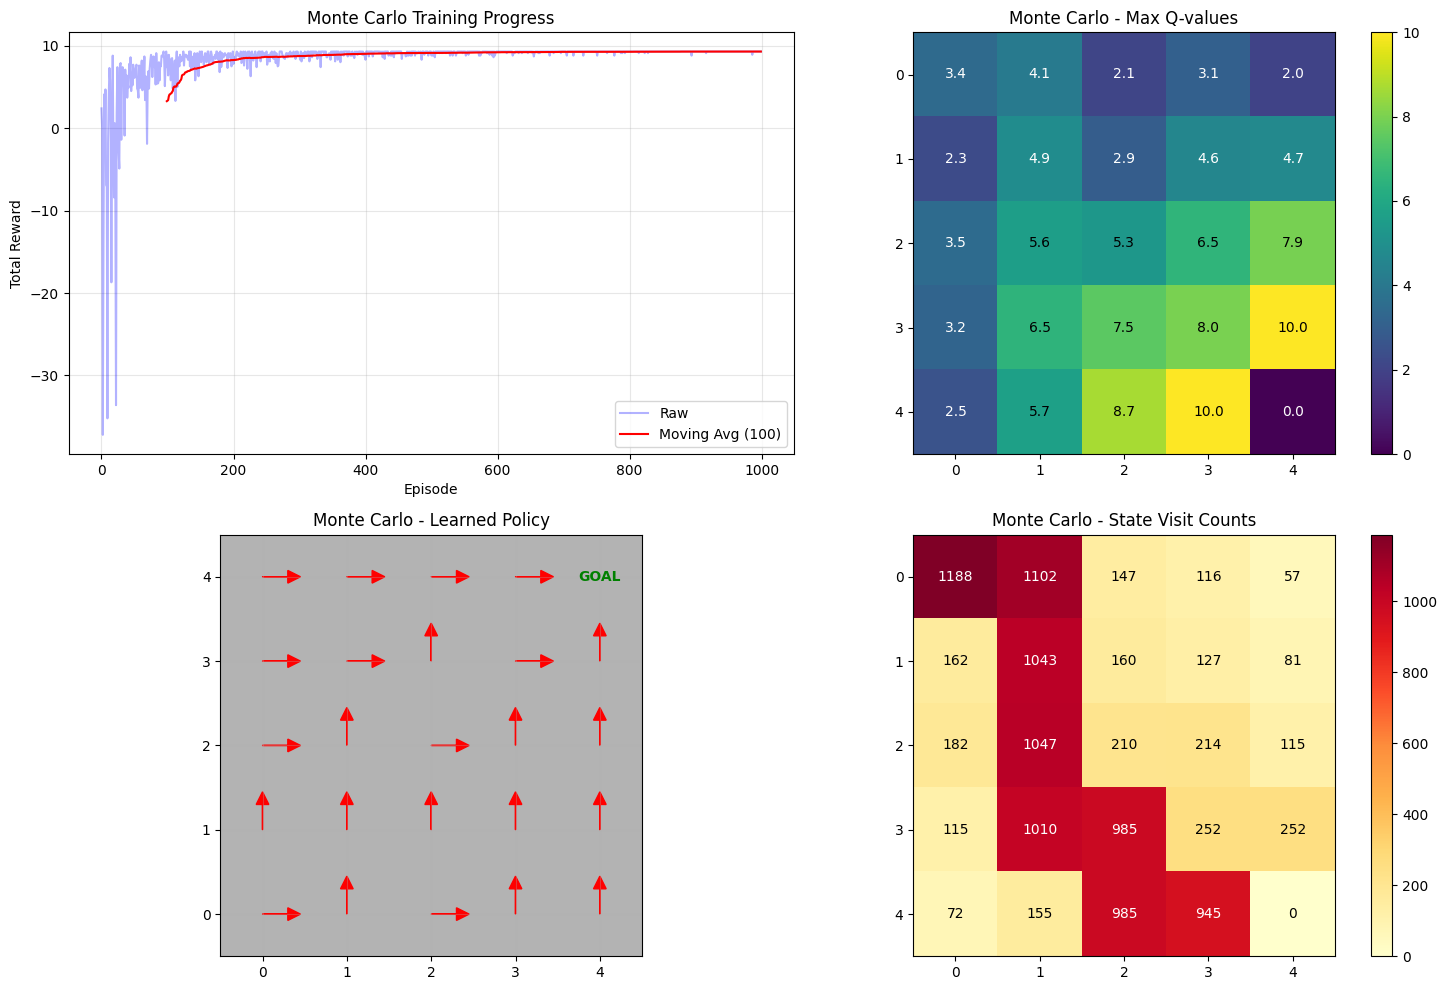

In [10]:
class MonteCarloAgent:
    """
    Monte Carlo Agent - Model-free reinforcement learning using episode sampling
    
    Uses first-visit Monte Carlo method:
    - Collects complete episodes
    - Updates value estimates based on actual returns
    - Uses epsilon-greedy policy improvement
    """
    
    def __init__(self, env: GridWorldEnv, discount=0.9, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.env = env
        self.discount = discount
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        
        # Initialize Q-table and visit counts
        self.q_table = {}
        self.returns = {}  # Store returns for each state-action pair
        self.visit_counts = {}
        
        for row in range(env.size):
            for col in range(env.size):
                state = (row, col)
                self.q_table[state] = [0.0] * len(env.action_space)
                self.returns[state] = [[] for _ in range(len(env.action_space))]
                self.visit_counts[state] = [0] * len(env.action_space)
        
        # Training tracking
        self.training_rewards = []
        self.training_steps = []
        
        # Train the agent
        self.train(episodes=1000)  # MC usually needs more episodes
    
    def get_action(self, observation):
        """Epsilon-greedy action selection"""
        if np.random.random() < self.epsilon:
            return np.random.choice(self.env.action_space)
        else:
            q_values = self.q_table[observation]
            # Handle ties by random selection
            max_q = max(q_values)
            best_actions = [a for a, q in enumerate(q_values) if q == max_q]
            return np.random.choice(best_actions)
    
    def generate_episode(self):
        """Generate a complete episode"""
        episode = []
        observation, _ = self.env.reset()
        
        for step in range(200):  # Max steps per episode
            action = self.get_action(observation)
            next_observation, reward, terminated, truncated, _ = self.env.step(action)
            
            episode.append((observation, action, reward))
            observation = next_observation
            
            if terminated or truncated:
                break
        
        return episode
    
    def update_from_episode(self, episode):
        """Update Q-values from a complete episode using first-visit MC"""
        # Calculate returns for each step
        G = 0
        visited_state_actions = set()
        
        # Work backwards through episode
        for t in reversed(range(len(episode))):
            state, action, reward = episode[t]
            G = self.discount * G + reward
            
            # First-visit Monte Carlo
            if (state, action) not in visited_state_actions:
                visited_state_actions.add((state, action))
                
                # Update return list and Q-value
                self.returns[state][action].append(G)
                self.visit_counts[state][action] += 1
                self.q_table[state][action] = np.mean(self.returns[state][action])
    
    def train(self, episodes=1000):
        """Train the Monte Carlo agent"""
        print(f"Training Monte Carlo agent for {episodes} episodes...")
        success_count = 0
        
        for episode_num in range(episodes):
            # Generate episode
            episode = self.generate_episode()
            
            # Check if successful
            if len(episode) > 0 and episode[-1][2] > 5:  # Last reward > 5 means reached goal
                success_count += 1
            
            # Calculate episode statistics
            total_reward = sum(reward for _, _, reward in episode)
            steps = len(episode)
            
            self.training_rewards.append(total_reward)
            self.training_steps.append(steps)
            
            # Update Q-values
            self.update_from_episode(episode)
            
            # Decay epsilon
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay
            
            # Progress update
            if (episode_num + 1) % 200 == 0:
                avg_reward = np.mean(self.training_rewards[-200:])
                avg_steps = np.mean(self.training_steps[-200:])
                success_rate = (success_count / (episode_num + 1)) * 100
                print(f"Episode {episode_num + 1}: Avg Reward: {avg_reward:.2f}, Success Rate: {success_rate:.1f}%, Epsilon: {self.epsilon:.3f}")
        
        # Set epsilon to 0 for testing
        self.epsilon = 0
        print(f"Training completed! Final success rate: {(success_count / episodes) * 100:.1f}%")
    
    def reset(self):
        """Reset agent"""
        pass

# Create and test Monte Carlo agent
print("Creating Monte Carlo Agent...")
mc_agent = MonteCarloAgent(env)

# Test the agent
print("\nTesting Monte Carlo Agent:")
mc_result = run_episode(env, mc_agent, render=False, max_steps=50)
print(f"Monte Carlo Result: {'SUCCESS' if mc_result['success'] else 'FAILED'} in {mc_result['steps']} steps")
print(f"Total reward: {mc_result['total_reward']:.2f}")

# Visualize Monte Carlo results
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Plot training progress
window_size = 100
if len(mc_agent.training_rewards) > window_size:
    smoothed_rewards = np.convolve(mc_agent.training_rewards, np.ones(window_size)/window_size, mode='valid')
    ax1.plot(mc_agent.training_rewards, alpha=0.3, color='blue', label='Raw')
    ax1.plot(range(window_size-1, len(mc_agent.training_rewards)), smoothed_rewards, color='red', label=f'Moving Avg ({window_size})')
else:
    ax1.plot(mc_agent.training_rewards, color='blue', label='Training Rewards')
ax1.set_xlabel('Episode')
ax1.set_ylabel('Total Reward')
ax1.set_title('Monte Carlo Training Progress')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot Q-values heatmap
q_values_max = np.zeros((env.size, env.size))
for row in range(env.size):
    for col in range(env.size):
        q_values_max[row, col] = max(mc_agent.q_table[(row, col)])

im = ax2.imshow(q_values_max, cmap='viridis')
ax2.set_title('Monte Carlo - Max Q-values')
for row in range(env.size):
    for col in range(env.size):
        ax2.text(col, row, f'{q_values_max[row, col]:.1f}', 
                ha='center', va='center', color='white' if q_values_max[row, col] < np.max(q_values_max)/2 else 'black')
plt.colorbar(im, ax=ax2)

# Plot learned policy
ax3.imshow(np.zeros((env.size, env.size)), cmap='gray', alpha=0.3)
for row in range(env.size):
    for col in range(env.size):
        if (row, col) == env.goal_pos:
            ax3.text(col, row, 'GOAL', ha='center', va='center', fontweight='bold', color='green')
            continue
        
        q_values = mc_agent.q_table[(row, col)]
        best_action = np.argmax(q_values)
        dx, dy = action_arrows[best_action]
        ax3.arrow(col, row, dx, dy, **arrow_props)

ax3.set_title('Monte Carlo - Learned Policy')
ax3.set_xlim(-0.5, env.size - 0.5)
ax3.set_ylim(-0.5, env.size - 0.5)
ax3.grid(True, alpha=0.3)

# Plot visit counts heatmap
visit_counts_total = np.zeros((env.size, env.size))
for row in range(env.size):
    for col in range(env.size):
        visit_counts_total[row, col] = sum(mc_agent.visit_counts[(row, col)])

im2 = ax4.imshow(visit_counts_total, cmap='YlOrRd')
ax4.set_title('Monte Carlo - State Visit Counts')
for row in range(env.size):
    for col in range(env.size):
        ax4.text(col, row, f'{int(visit_counts_total[row, col])}', 
                ha='center', va='center', 
                color='white' if visit_counts_total[row, col] > np.max(visit_counts_total)/2 else 'black')
plt.colorbar(im2, ax=ax4)

plt.tight_layout()
plt.show()

## 9. Agent Comparison and Analysis

🏆 COMPREHENSIVE AGENT COMPARISON

Testing Random...
Starting episode at (0, 0)
Episode finished: SUCCESS in 30 steps
Total reward: 4.70
Final position: (4, 4)
Starting episode at (0, 0)
Episode finished: SUCCESS in 85 steps
Total reward: -4.40
Final position: (4, 4)
Starting episode at (0, 0)
Episode finished: SUCCESS in 46 steps
Total reward: 1.50
Final position: (4, 4)
Starting episode at (0, 0)
Episode finished: SUCCESS in 42 steps
Total reward: 1.10
Final position: (4, 4)
Starting episode at (0, 0)
Episode finished: TRUNCATED in 100 steps
Total reward: -15.60
Final position: (1, 1)
Starting episode at (0, 0)
Episode finished: TRUNCATED in 100 steps
Total reward: -19.20
Final position: (1, 2)
Starting episode at (0, 0)
Episode finished: TRUNCATED in 100 steps
Total reward: -16.40
Final position: (0, 2)
Starting episode at (0, 0)
Episode finished: TRUNCATED in 100 steps
Total reward: -17.60
Final position: (0, 1)
Starting episode at (0, 0)
Episode finished: SUCCESS in 49 steps
Total 

C:\Users\Mouhcine\AppData\Local\Temp\ipykernel_5764\3147184146.py:120: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax3.boxplot(reward_data, labels=agent_names, patch_artist=True)
C:\Users\Mouhcine\AppData\Local\Temp\ipykernel_5764\3147184146.py:131: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp2 = ax4.boxplot(steps_data, labels=agent_names, patch_artist=True)


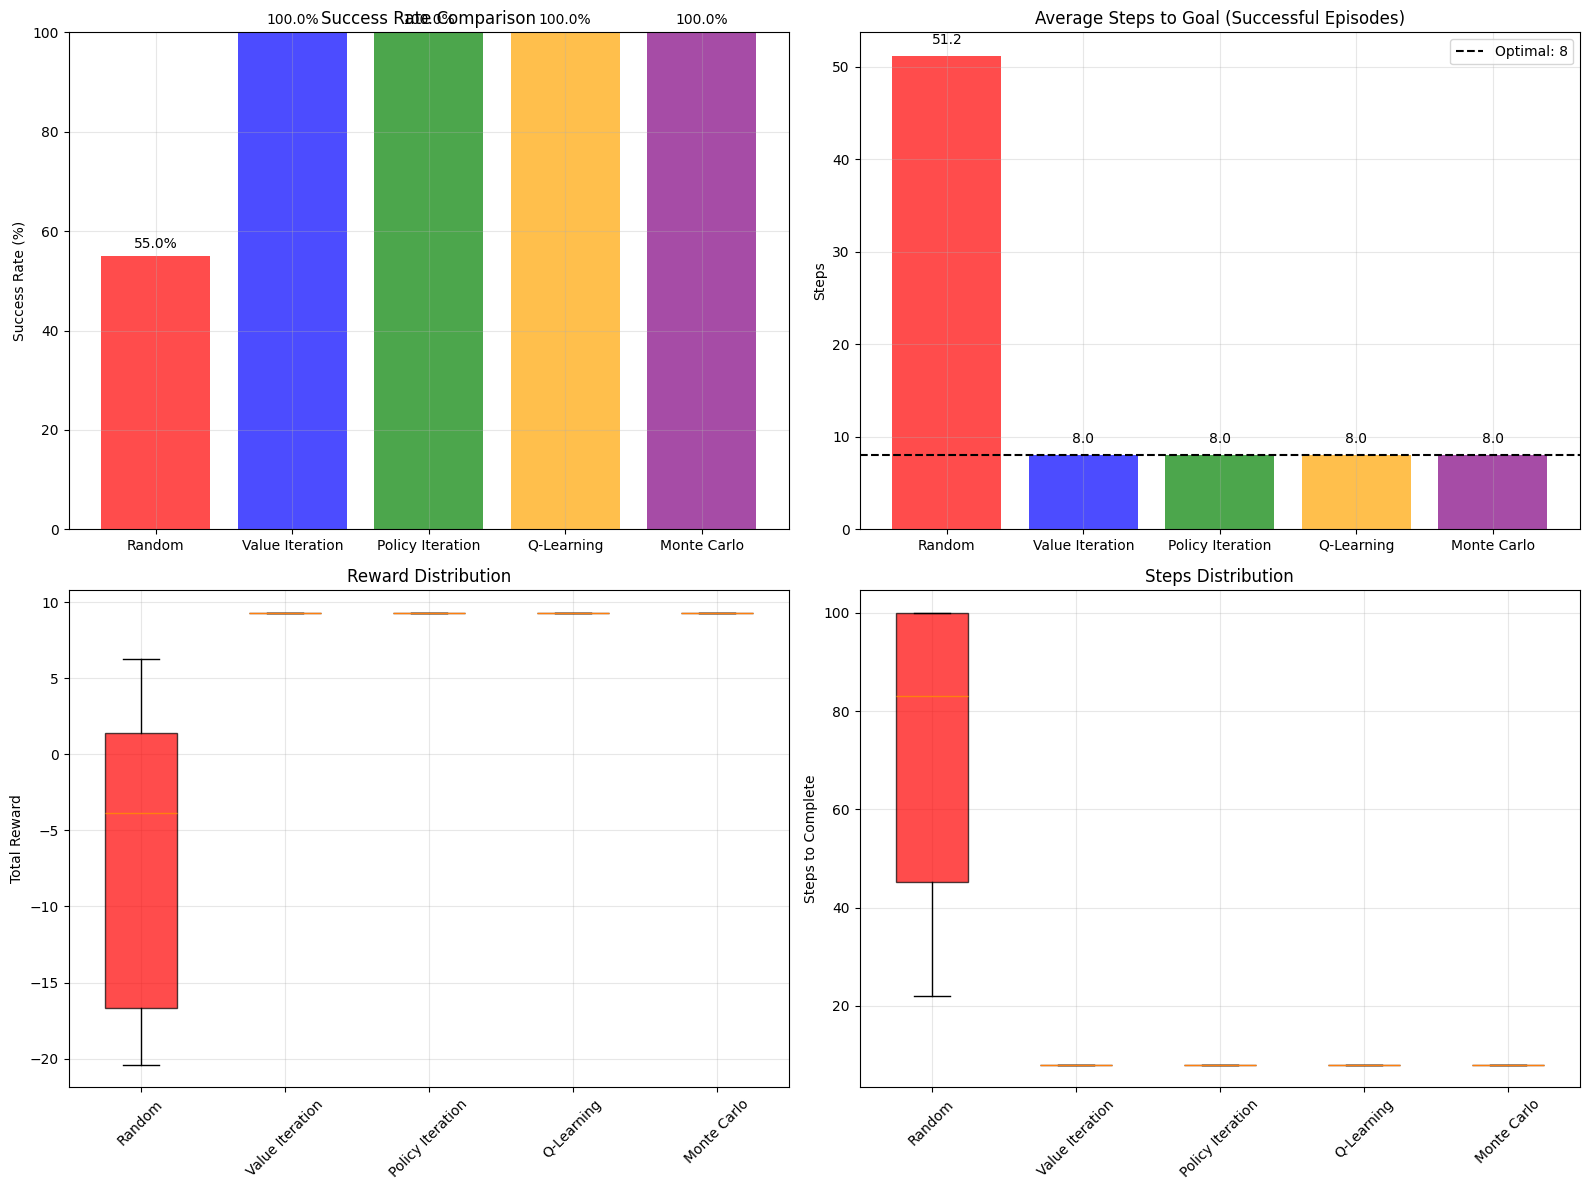

In [12]:
def compare_all_agents():
    """
    Compare all agents across multiple episodes
    """
    agents = {
        'Random': agent,
        'Value Iteration': vi_agent,
        'Policy Iteration': pi_agent, 
        'Q-Learning': ql_agent,
        'Monte Carlo': mc_agent
    }
    
    print("🏆 COMPREHENSIVE AGENT COMPARISON")
    print("=" * 60)
    
    # Test each agent multiple times
    num_test_episodes = 20
    results = {}
    
    for agent_name, agent_obj in agents.items():
        print(f"\nTesting {agent_name}...")
        
        episode_results = []
        success_count = 0
        total_rewards = []
        episode_steps = []
        
        for test in range(num_test_episodes):
            result = run_episode(env, agent_obj, render=False, max_steps=100)
            episode_results.append(result)
            
            if result['success']:
                success_count += 1
            
            total_rewards.append(result['total_reward'])
            episode_steps.append(result['steps'])
        
        # Calculate statistics
        success_rate = (success_count / num_test_episodes) * 100
        avg_reward = np.mean(total_rewards)
        std_reward = np.std(total_rewards)
        avg_steps = np.mean(episode_steps)
        std_steps = np.std(episode_steps)
        
        # Success-only statistics
        successful_episodes = [r for r in episode_results if r['success']]
        if successful_episodes:
            successful_rewards = [r['total_reward'] for r in successful_episodes]
            successful_steps = [r['steps'] for r in successful_episodes]
            avg_successful_reward = np.mean(successful_rewards)
            avg_successful_steps = np.mean(successful_steps)
        else:
            avg_successful_reward = 0
            avg_successful_steps = float('inf')
        
        results[agent_name] = {
            'success_rate': success_rate,
            'avg_reward': avg_reward,
            'std_reward': std_reward,
            'avg_steps': avg_steps,
            'std_steps': std_steps,
            'avg_successful_reward': avg_successful_reward,
            'avg_successful_steps': avg_successful_steps,
            'all_rewards': total_rewards,
            'all_steps': episode_steps
        }
    
    # Create comparison table
    print(f"\n📊 PERFORMANCE SUMMARY")
    print("=" * 100)
    print(f"{'Agent':<15} {'Success Rate':<12} {'Avg Steps':<12} {'Avg Reward':<12} {'Optimal Steps':<12}")
    print("-" * 100)
    
    optimal_steps = abs(env.goal_pos[0] - env.start_pos[0]) + abs(env.goal_pos[1] - env.start_pos[1])
    
    for agent_name, stats in results.items():
        efficiency = f"{optimal_steps:.1f}" if stats['avg_successful_steps'] == float('inf') else f"{optimal_steps:.1f}"
        print(f"{agent_name:<15} {stats['success_rate']:<11.1f}% {stats['avg_successful_steps']:<11.1f} "
              f"{stats['avg_successful_reward']:<11.2f} {efficiency:<12}")
    
    # Visualize comparison
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    agent_names = list(results.keys())
    colors = ['red', 'blue', 'green', 'orange', 'purple']
    
    # 1. Success rates
    success_rates = [results[name]['success_rate'] for name in agent_names]
    bars1 = ax1.bar(agent_names, success_rates, color=colors, alpha=0.7)
    ax1.set_title('Success Rate Comparison')
    ax1.set_ylabel('Success Rate (%)')
    ax1.set_ylim(0, 100)
    ax1.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, bar in enumerate(bars1):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 1, f'{height:.1f}%', 
                ha='center', va='bottom')
    
    # 2. Average steps for successful episodes
    successful_steps = [results[name]['avg_successful_steps'] if results[name]['avg_successful_steps'] != float('inf') else 100 
                       for name in agent_names]
    bars2 = ax2.bar(agent_names, successful_steps, color=colors, alpha=0.7)
    ax2.axhline(y=optimal_steps, color='black', linestyle='--', label=f'Optimal: {optimal_steps}')
    ax2.set_title('Average Steps to Goal (Successful Episodes)')
    ax2.set_ylabel('Steps')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, bar in enumerate(bars2):
        height = bar.get_height()
        if height < 100:  # Only show if not infinity
            ax2.text(bar.get_x() + bar.get_width()/2., height + 1, f'{height:.1f}', 
                    ha='center', va='bottom')
    
    # 3. Box plot of rewards
    reward_data = [results[name]['all_rewards'] for name in agent_names]
    bp = ax3.boxplot(reward_data, labels=agent_names, patch_artist=True)
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    ax3.set_title('Reward Distribution')
    ax3.set_ylabel('Total Reward')
    ax3.grid(True, alpha=0.3)
    plt.setp(ax3.get_xticklabels(), rotation=45)
    
    # 4. Box plot of steps
    steps_data = [results[name]['all_steps'] for name in agent_names]
    bp2 = ax4.boxplot(steps_data, labels=agent_names, patch_artist=True)
    for patch, color in zip(bp2['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    ax4.set_title('Steps Distribution')
    ax4.set_ylabel('Steps to Complete')
    ax4.grid(True, alpha=0.3)
    plt.setp(ax4.get_xticklabels(), rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return results

# Run comprehensive comparison
comparison_results = compare_all_agents()


# Clean up
env.close()